# ABOUT:
- this notebook compares the recommendation performance between Popularity recommender, SAR, and LightGCN on Shopee dataset

In [1]:
from recommenders.models.sar import SAR
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.evaluation.python_evaluation import precision_at_k
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.utils.timer import Timer

import pandas as pd
import os
import gzip
import json
import pandas as pd
import seaborn as sb
from scipy.sparse import save_npz, load_npz
from numpy import save, load 
import json
import numpy as np
import sys
sys.path.append(r'C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\fastapi')
from model_utils import convert_numpy_keys_to_raw, save_sar, sar_load

### config

In [5]:
KEYWORD_SHOPEE_RAW_TRANSACTION_FILE = "Order.all"
NON_KEYWORD_SHOPEE_RAW_TRANSACTION_FILE = "$"
DESIRED_COLS_TRANSACTION_FILE = ["Order ID", "Original Price", "Username (Buyer)", "Product Name", "product_id"]
TRANSACTION_ID_COL = ["Order ID"]
USER_ID_COL = "user_id"
ITEM_ID_COL = "item_id"
RATING_COL = "rating"
TRANSACTION_TO_INTERACTION_MAPPING = {
    USER_ID_COL:"Username (Buyer)",
    ITEM_ID_COL:"product_id",
}
MIN_UNIQUE_PURCHASES = 2
SPLIT_RATIO = 0.5
SEED = 0 
TOP_K = 10
BATCH_SIZE = 1024
MODEL_DIR = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\models"
PATH_TO_RAW_MEDIA_FILE = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\shopee\mass_update_media_info_120171733_20230224232836.xlsx"
PATH_TO_RAW_TRANSACTIONS_FOLDER = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\shopee"

### Utils

In [3]:
"""
files containing the transactions are identified by keywords
IMPORTANT NOTE: transaction files SHOULD NOT be duplicated
"""
def get_transaction_filenames(folder_path:str, keyword:str, non_keyword:str):
    return [filename for filename in os.listdir(folder_path) if keyword in filename and non_keyword not in filename]
"""
Combine all transaction data into dataframe, with no processing 
"""
def get_transaction_data(folder_path:str, filenames:list):
    output = pd.DataFrame()
    for filename in filenames:
        data_path = os.path.join(folder_path,filename)
        data = pd.read_excel(data_path)
        output = pd.concat([output, data] , axis = 0)
    return output.reset_index(drop = True)
"""
Clean transaction data - very minimal cleaning
"""
def clean_transaction_data(dataframe, desired_columns):
    output = dataframe.copy()
    output = output[desired_columns]
    # # INTERACTIONS ARE UNIQUE BY COMPOSITE/MULTIPLE COLUMNS
    # output = output.drop_duplicates(subset = id_cols)
    return output
"""
Create a id mapping for a column
"""
def generate_ids(pandas_series):
    mapping = dict(enumerate(pandas_series.unique().tolist()))
    reverse_mapping = {v:k for k,v in mapping.items()}
    return reverse_mapping
"""
Transform into interaction data that is the input to personalized recommendation models
"""
def transform_transaction_to_interaction_data(transaction_dataframe, user_id_col, item_id_col, transaction_interaction_mapping, rating_col, generate_ids = False):
    output = pd.DataFrame()
    user_id_mapping, item_id_mapping = None, None
    if generate_ids:
        user_id_mapping = generate_ids(transaction_dataframe[transaction_interaction_mapping[user_id_col]])
        item_id_mapping = generate_ids(transaction_dataframe[transaction_interaction_mapping[item_id_col]])
        output[user_id_col] = transaction_dataframe[transaction_interaction_mapping[user_id_col]].map(user_id_mapping)
        output[item_id_col] = transaction_dataframe[transaction_interaction_mapping[item_id_col]].map(item_id_mapping)
    else: 
        output[user_id_col] = transaction_dataframe[transaction_interaction_mapping[user_id_col]]
        output[item_id_col] = transaction_dataframe[transaction_interaction_mapping[item_id_col]]
    output = pd.DataFrame(output.groupby(by = [user_id_col, item_id_col]).size(), columns = [rating_col])
    output = output.reset_index()
    return output, user_id_mapping, item_id_mapping
"""
Make interaction data more suitable for recommedation model 
e.g. keep only warm users
"""
def clean_interaction_data(dataframe, user_id_col, item_id_col, rating_col, min_purchases, equalize_interaction_weights = True):
    # keep the user col warm - users should have at least x number of purchases
    output = keep_warm(dataframe, user_id_col, min_purchases)
    if equalize_interaction_weights:
        dataframe[rating_col] = 1
    return output
"""
Warm users refer to users that have bought at least x number of items from the shop
"""
def keep_warm(dataframe, target_col, minimum_count):
    output = dataframe.groupby(by = [target_col]).filter(lambda x : len(x)>=minimum_count)
    return output.reset_index(drop = True)


def show_dataset_stats(dataframe):
    print(f"""
        Total Interactions: {len(dataframe)}
        Unique Users: {dataframe[USER_ID_COL].nunique()}
        Unique Items: {dataframe[ITEM_ID_COL].nunique()}
        """)
    


### Get raw data
- consists of transactional files (user item interactions) ad media files (image urls)

In [6]:
def get_product_data():
    data = pd.read_excel(PATH_TO_RAW_MEDIA_FILE
                  ,sheet_name= "Sheet2", header = None, names = ["product_id", "product_name", "categories", "image_url"])
    return data
media_data = get_product_data()

In [37]:
media_data

,product_id,product_name,categories,image_url
0,23826146098,Ultrasonic Aroma Humidifier Led light changing,101129 - Home & Living/Home Fragrance & Aromat...,https://cf.shopee.sg/file/sg-11134207-23020-9n...
1,23821255327,Heavy Duty Canvas Tote Bags Stitching Contrast...,100093 - Women Bags/Tote Bags,https://cf.shopee.sg/file/sg-11134207-23020-yu...
2,23821254972,Hot Products EMS Vibration RF V Shape Other Ho...,101661 - Beauty/Beauty Tools/Facial Care Tools...,https://cf.shopee.sg/file/sg-11134207-23020-k1...
3,23821143235,Wart Removal Cream Natural Herbal Skin Care Re...,100427 - Health/Medical Supplies/First Aid Sup...,https://cf.shopee.sg/file/sg-11134207-23020-1u...
4,23720393304,Cute Kids Bag Cartoon Schoolbag Shoulder Bag S...,101744 - Baby & Kids Fashion/Baby & Kids Acces...,https://cf.shopee.sg/file/sg-11134207-23010-t7...
...,...,...,...,...
344,3333330067,Bunion Corrector Orthopedic Bunion Correctors ...,100434 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/2d0a78daa545c110ebc0...
345,3295377541,Magnetic Therapy Self-Heating Arm Elbow Brace ...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/e17d4f826ffdb4cf90d4...
346,3295353571,Carpal Tunnel Wrist Brace Support - Wrist Spli...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/d261a9b88a65ef8a108b...
347,3233299909,Sport Face Mask with Activated Carbon Pm 2.5 r...,100128 - Health/Medical Supplies/Medical Glove...,https://cf.shopee.sg/file/84930df960f41efc7afc...


In [6]:
media_data.head()

,product_id,product_name,categories,image_url
0,23826146098,Ultrasonic Aroma Humidifier Led light changing,101129 - Home & Living/Home Fragrance & Aromat...,https://cf.shopee.sg/file/sg-11134207-23020-9n...
1,23821255327,Heavy Duty Canvas Tote Bags Stitching Contrast...,100093 - Women Bags/Tote Bags,https://cf.shopee.sg/file/sg-11134207-23020-yu...
2,23821254972,Hot Products EMS Vibration RF V Shape Other Ho...,101661 - Beauty/Beauty Tools/Facial Care Tools...,https://cf.shopee.sg/file/sg-11134207-23020-k1...
3,23821143235,Wart Removal Cream Natural Herbal Skin Care Re...,100427 - Health/Medical Supplies/First Aid Sup...,https://cf.shopee.sg/file/sg-11134207-23020-1u...
4,23720393304,Cute Kids Bag Cartoon Schoolbag Shoulder Bag S...,101744 - Baby & Kids Fashion/Baby & Kids Acces...,https://cf.shopee.sg/file/sg-11134207-23010-t7...


In [7]:
# media_data.to_csv(os.path.join(PATH_TO_RAW_TRANSACTIONS_FOLDER, "cleaned_transactions.csv"), index = False)

In [7]:
transaction_filenames = get_transaction_filenames(PATH_TO_RAW_TRANSACTIONS_FOLDER, KEYWORD_SHOPEE_RAW_TRANSACTION_FILE, NON_KEYWORD_SHOPEE_RAW_TRANSACTION_FILE)
transaction_data = get_transaction_data(PATH_TO_RAW_TRANSACTIONS_FOLDER, transaction_filenames)

In [8]:
transaction_data = transaction_data.merge(media_data, left_on = "Product Name", right_on = "product_name", how = "inner")

In [12]:
transaction_data.head()

,Order ID,Order Status,Cancel reason,Return / Refund Status,Tracking Number*,Shipping Option,Shipment Method,Estimated Ship Out Date,Ship Time,Order Creation Date,...,Province,Country,Zip Code,Remark from buyer,Order Complete Time,Note,product_id,product_name,categories,image_url
0,210701QSRHFY5W,Completed,NaN,NaN,SJNT957750266,J&T Express,pickup,2021-07-05 13:52,2021-07-02 16:45,2021-07-01 13:52,...,NaN,SG,734688,NaN,2021-07-03 20:34,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
1,210708D2XTB5TJ,Completed,NaN,NaN,SJNT390072266,J&T Express,pickup,2021-07-12 21:24,2021-07-09 18:42,2021-07-08 21:24,...,NaN,SG,459109,NaN,2021-07-16 08:08,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
2,210725SHRE6FM4,Completed,NaN,NaN,SJNT345680452,J&T Express,pickup,2021-07-27 10:08,2021-07-26 14:33,2021-07-25 10:07,...,NaN,SG,545084,NaN,2021-07-30 21:44,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
3,211002RFG2874R,Completed,NaN,NaN,SJNT585561873,J&T Express,pickup,2021-10-05 10:35,2021-10-02 13:39,2021-10-02 10:34,...,NaN,SG,208787,NaN,2021-10-04 12:37,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
4,21100545WNFN2V,Cancelled,Cancelled by buyer. Reason: Others,NaN,NaN,J&T Express,pickup,NaN,NaN,2021-10-05 22:36,...,NaN,SG,460106,NaN,NaN,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...


### Data PreProcessing
- Convert Raw Transactional Data into Interaction Data that can be input into recommender models
- Highlight steps:
    - Interaction Data Should be Warm - i.e. users should have at least x purchases, where x must be above 1
    - Item and User Names are mapped to IDs
    - If a customer buys an item multiple times, that information gets added to the "rating" column, denoting the strength of the r/s

In [13]:
processed_transaction_data = clean_transaction_data(transaction_data, DESIRED_COLS_TRANSACTION_FILE)

In [14]:
processed_transaction_data.head()

,Order ID,Original Price,Username (Buyer),Product Name,product_id
0,210701QSRHFY5W,15.8,iralia7801,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
1,210708D2XTB5TJ,15.8,z8852ay3gp,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
2,210725SHRE6FM4,9.9,6ltmsjbpw2,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
3,211002RFG2874R,9.9,obuia9a4kv,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
4,21100545WNFN2V,9.9,ahliahyunos,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315


In [15]:
interaction_data,user_id_mapping, item_id_mapping = transform_transaction_to_interaction_data(processed_transaction_data, USER_ID_COL, ITEM_ID_COL, TRANSACTION_TO_INTERACTION_MAPPING, RATING_COL)

In [50]:
interaction_data

,user_id,item_id,rating
0,.naminani_,12009015584,1
1,.xinyi.89,15886095522,1
2,00dwnptymc,10690827974,1
3,02utgw4m43,21837443125,1
4,02ynohtnakram,12192722728,1
...,...,...,...
8128,zygardo,13671455179,1
8129,zyza208,20901098335,1
8130,zziplex,20901098335,1
8131,zzzaharazzz,13671455179,1


In [16]:
interaction_data.head()

,user_id,item_id,rating
0,.naminani_,12009015584,1
1,.xinyi.89,15886095522,1
2,00dwnptymc,10690827974,4
3,02utgw4m43,21837443125,1
4,02ynohtnakram,12192722728,1


In [17]:
processed_interaction_data  = clean_interaction_data(interaction_data, USER_ID_COL, ITEM_ID_COL, RATING_COL, MIN_UNIQUE_PURCHASES)

In [59]:
type(processed_interaction_data.iloc[0,1].item())

int

In [62]:
tmp = processed_interaction_data.item_id.apply(lambda ID: ID if isinstance(ID, int) else ID.item())

In [67]:
type(int(tmp[0]))

int

In [55]:
processed_interaction_data.user_id.astype(str)

0         1cp2upf59l
1         1cp2upf59l
2         1cp2upf59l
3         1cp2upf59l
4         1cp2upf59l
            ...     
1617    zubaidahraup
1618    zubaidahraup
1619         zvimyrl
1620         zvimyrl
1621         zvimyrl
Name: user_id, Length: 1622, dtype: object

In [52]:
processed_interaction_data.dtypes

user_id    object
item_id     int64
rating      int64
dtype: object

### Data Statistics
- After converting the interaction data to warm, the number of interactions drop drastically. 
    - meaning that most users that purchases items from this shop are new users
    - each user will have at least MIN_UNIQUE_PURCHASES unique item purchases 

In [19]:
show_dataset_stats(interaction_data)


        Total Interactions: 8133
        Unique Users: 7222
        Unique Items: 248
        


In [20]:
show_dataset_stats(processed_interaction_data)


        Total Interactions: 1622
        Unique Users: 711
        Unique Items: 171
        


In [21]:
processed_interaction_data[USER_ID_COL].value_counts()

weirdyellow           12
54bakery               8
alexsanzo              7
bignphat               7
ms.idaa89              6
                      ..
jolenetong95           2
josephchua123          2
ashiethamrinsayson     2
joytan74               2
maxdriller             2
Name: user_id, Length: 711, dtype: int64

### Train and Test Processing
- Since user have at least 2 interactions we perform a 50/50 stratified split on the user

In [22]:
train, test = python_stratified_split(processed_interaction_data, ratio=SPLIT_RATIO,
                                      min_rating=1, filter_by='user', 
                                      col_user=USER_ID_COL, col_item=ITEM_ID_COL, 
                                      seed=SEED)

In [23]:
show_dataset_stats(train)


        Total Interactions: 853
        Unique Users: 711
        Unique Items: 151
        


In [24]:
show_dataset_stats(test)


        Total Interactions: 769
        Unique Users: 711
        Unique Items: 107
        


In [4]:
# test.to_pickle(r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\interaction data\test.pkl")
# train.to_pickle(r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\interaction data\train.pkl")

In [6]:
train = pd.read_pickle(r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\interaction data\train.pkl")
test = pd.read_pickle(r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\interaction data\test.pkl")

## Model Training and Evaluation: SAR

In [25]:
# Similarity types: ["cooccurrence" | "cosine" | "inclusion index" | "jaccard" | "lift" | "mutual information" | "lexicographers mutual information"]
model_sar = SAR(
    col_user=USER_ID_COL,
    col_item=ITEM_ID_COL,
    col_rating=RATING_COL,
    # col_timestamp=COL_TIMESTAMP,
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    timedecay_formula=False,
    normalize=False
)

In [26]:
# with Timer() as train_time:
model_sar.fit(train)

In [27]:
top_k = model_sar.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
eval_precision = precision_at_k(test, top_k, col_user=USER_ID_COL, col_item=ITEM_ID_COL, col_rating=RATING_COL, k=TOP_K)
eval_precision   

0.03530239099859353

In [25]:
save_sar(model_sar, 
         MODEL_DIR,
         "arietes-sar")

In [26]:
sar_load(model_sar, r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\models\arietes-sar")

## Train and Evaluate: Popularity Recommender

In [27]:
def construct_popular_predictions_table(test, model, top_k):
    user_ids = test.user_id.unique()
    popular_items = model.get_popularity_based_topk(top_k = top_k)
    output = pd.DataFrame()
    for user_id in user_ids:
        popular_items["user_id"] = user_id
        output = pd.concat([output, popular_items], axis = 0)
    return output

In [61]:
top_k = construct_popular_predictions_table(test = test, model = model_sar, top_k = TOP_K)
eval_precision = precision_at_k(test, top_k, col_user=USER_ID_COL, col_item=ITEM_ID_COL, col_rating=RATING_COL, k=TOP_K)
eval_precision  

0.021940928270042192

## Train and Evaluate: LightGCN

In [16]:
yaml_file = r"./lightgcn.yml"
save_model = False
save_epoch = 50

In [17]:
data = ImplicitCF(train = train, test=test, 
                  adj_dir=None, 
                  col_user=USER_ID_COL, col_item=ITEM_ID_COL, 
                  col_rating = RATING_COL,
                  seed=SEED)

C:\Users\tanch\anaconda3\envs\fyp1\lib\site-packages\recommenders\models\deeprec\DataModel\ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


In [18]:
loss_type = "AmpBPR2"
# loss_type = "OriginalBPR"
# loss_type = "AmpBPR2"
loss_neg_weight = 1.9
log_wandb = False

In [19]:
hparams = prepare_hparams(yaml_file,
                              n_layers=2,
                              loss_type = loss_type, 
                              loss_neg_weight = loss_neg_weight, 
                              log_wandb = log_wandb,
                              batch_size=BATCH_SIZE,
                              epochs=50,
                              learning_rate=0.01,
                              eval_epoch=1,
                              top_k=TOP_K,
                              COL_USER = USER_ID_COL,
                              COL_ITEM = ITEM_ID_COL,
                              COL_RATING = RATING_COL,
                              save_model = save_model,
                            save_epoch = save_epoch,
                            MODEL_DIR = MODEL_DIR
                              )
# initiate model
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [14]:
hparams = prepare_hparams(yaml_file,
                              n_layers=2,
                              loss_type = loss_type, 
                              loss_neg_weight = loss_neg_weight, 
                              log_wandb = log_wandb,
                              batch_size=BATCH_SIZE,
                              epochs=50,
                              learning_rate=0.01,
                              eval_epoch=1,
                              top_k=TOP_K,
                              COL_USER = USER_ID_COL,
                              COL_ITEM = ITEM_ID_COL,
                              COL_RATING = RATING_COL,
                              save_model = save_model,
                            save_epoch = save_epoch,
                            MODEL_DIR = MODEL_DIR
                              )

In [ ]:
model = LightGCN(hparams, data = None, seed=SEED)

In [23]:
model.sess

In [20]:
model.fit()

Epoch 1 (train)0.1s + (eval)0.0s: train loss = 0.68038 = (mf)0.68034 + (embed)0.00004, precision = 0.00703
Epoch 2 (train)0.0s + (eval)0.0s: train loss = 0.67198 = (mf)0.67194 + (embed)0.00004, precision = 0.00886
Epoch 3 (train)0.0s + (eval)0.0s: train loss = 0.65997 = (mf)0.65993 + (embed)0.00004, precision = 0.01378
Epoch 4 (train)0.0s + (eval)0.0s: train loss = 0.64632 = (mf)0.64627 + (embed)0.00005, precision = 0.02082
Epoch 5 (train)0.0s + (eval)0.0s: train loss = 0.62776 = (mf)0.62770 + (embed)0.00005, precision = 0.02714
Epoch 6 (train)0.0s + (eval)0.0s: train loss = 0.60972 = (mf)0.60966 + (embed)0.00006, precision = 0.02968
Epoch 7 (train)0.0s + (eval)0.0s: train loss = 0.58550 = (mf)0.58543 + (embed)0.00007, precision = 0.03038
Epoch 8 (train)0.0s + (eval)0.0s: train loss = 0.56436 = (mf)0.56428 + (embed)0.00007, precision = 0.03066
Epoch 9 (train)0.0s + (eval)0.0s: train loss = 0.53338 = (mf)0.53329 + (embed)0.00008, precision = 0.03094
Epoch 10 (train)0.0s + (eval)0.0s: tr

## Comparison
- Similarities with ML100k:
    - Both SAR and LightGCN improves on Populairty recommender
    
- Differences with ML100k:
    - SAR performed better than LightGCN

- What we can learn is that both **CF recommenders can improve upon Simple Popularity recommendation**. That means that, if popularity recommendation achieves a score of 0.2 precision@10, we can expect the CF recommenders to improve to let's say 0.25~. But if popularity recommendation achieves a score of only 0.02, then we can expect CF recommenders to improve performances to say only 0.03. **Depending on the type and size of datasets, we can expect vastly different performances**. It is inconclusive as to whether SAR or LightGCN performs better, **different algorithms perform differently depending on the dataset**

In [62]:
import seaborn as sb

In [63]:
precison_tmp = {
    "LightGCN":0.03305, 
    "SAR":0.03530239099859353,
    "Popularity":0.021940928270042192
}   

[Text(0.5, 0, 'Precision@10')]

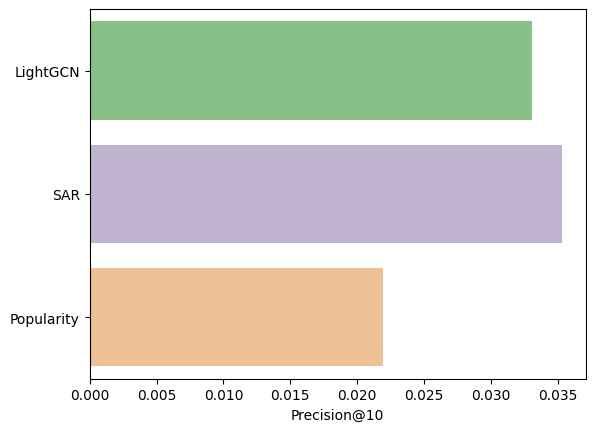

In [64]:
p = sb.barplot(x = list(precison_tmp.values()),y = list(precison_tmp.keys()), palette = "Accent")
p.set(xlabel = "Precision@10")

## load and predict

In [35]:
save_path_str = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\models\epoch_50"
model.load(save_path_str)
top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
eval_precision = precision_at_k(test, top_k, col_user=USER_ID_COL, col_item=ITEM_ID_COL, col_rating=RATING_COL, k=TOP_K)
eval_precision     

INFO:tensorflow:Restoring parameters from C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\models\epoch_50


0.005344585091420536

In [77]:
model.recommend_k_items(pd.DataFrame({"user_id":["1cp2upf59l"]}), top_k=TOP_K, remove_seen=True)

,user_id,item_id,prediction
0,1cp2upf59l,11845518959,1.731541
1,1cp2upf59l,18516275838,1.599467
2,1cp2upf59l,14303478270,1.242138
3,1cp2upf59l,14782140731,1.221002
4,1cp2upf59l,19564733962,1.061905
5,1cp2upf59l,15403421090,0.960976
6,1cp2upf59l,19906893746,0.942554
7,1cp2upf59l,14675758106,0.936188
8,1cp2upf59l,21433429878,0.828105
9,1cp2upf59l,13117027913,0.794699


In [1]:
import pandas as pd
data = pd.read_pickle(r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\interaction data\train.pkl")

In [8]:
data[data.user_id == "weirdyellow"   ].item_id

1508    17971710101
1513    22203168551
1506    16071702603
1512    21869596899
1504    14266408742
1510    20860078856
Name: item_id, dtype: int64

In [4]:
data.user_id.value_counts()[:10]

weirdyellow    6
alexsanzo      4
54bakery       4
bignphat       4
buycwy         3
lynasally      3
ms.idaa89      3
jelzheng       2
ismailtaib     2
johnwong435    2
Name: user_id, dtype: int64

In [11]:
media_data[media_data.product_id.isin(data[data.user_id == "weirdyellow"   ].item_id)]

,product_id,product_name,categories,image_url
33,22203168551,"Shoulder Ice Pack for Rotator Cuff Injuries, R...","100712 - Home & Living/Hand Warmers, Hot Water...",https://cf.shopee.sg/file/sg-11134201-22100-n8...
46,21869596899,Hip Ice Pack Wrap for Bursitis Pain Relief Reu...,"100712 - Home & Living/Hand Warmers, Hot Water...",https://cf.shopee.sg/file/sg-11134201-22120-x9...
84,20860078856,Wrist Ice Gel Pack with Support Brace for Hot ...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/sg-11134201-22110-f2...
158,17971710101,SG Seller Ankle Pain Relieve hot cool gel pack...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/2940d22807b793d0fec9...
210,16071702603,SG Seller Gel Ice pack Hot Cold Gel Bead Ice F...,100898 - Beauty/Skincare/Face Mask & Packs,https://cf.shopee.sg/file/22fd5268fa3093fd17ac...
242,14266408742,SG Seller Hot Cold Reusable and Flexible Gel I...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/ae1eaf10e8858389c737...
